In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import toolbox as tb;
import kaggleData as kD;
from sklearn import linear_model as linMod
from sklearn import neighbors

# Section DATA

## We want to test the classifiers with easy-seperable toy-data, so we need to generate some

Populating the interactive namespace from numpy and matplotlib


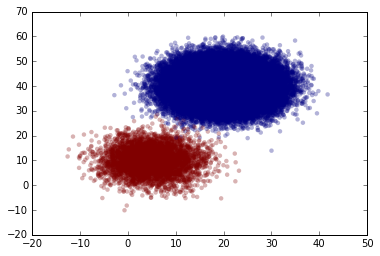

In [2]:
toy_data = tb.createToyData(n = 100000,dim = 4,s_prob = 0.05)
toy_weights = toy_data[:,0]
toy_labels = toy_data[:,1]
x = toy_data[:,2:4]

%pylab inline
plt.scatter(x[:,0], x[:,1], edgecolor="", c=toy_labels, alpha=0.3)

split toydata into training- and testset for the classifier

In [3]:
n_train = int(100000/10)

toy_train_x,toy_test_x = tb.splitList(x,n_train)
toy_train_labels,toy_test_labels = tb.splitList(toy_labels,n_train)
toy_test_weights = tb.splitList(toy_weights,n_train)[1]

For Comparison, we calculate the best possible AMS    
(case: every signal correctly detected)

In [4]:
tb.calcMaxAMS(toy_test_weights,toy_test_labels)

Found 4590 signals.
Weightsums signal: 116.345112685 | background: 0
Maximum AMS possible with this Data: 20.204983626217718


20.204983626217718

In [5]:
logReg = linMod.LogisticRegression()
logReg.fit(toy_train_x,toy_train_labels);
logReg.sparsify();

In [6]:
predProb = logReg.predict_proba(toy_test_x)
pred = logReg.predict(toy_test_x)

print("AMS:",tb.calcAMS(toy_test_weights,pred,toy_test_labels))

AMS: (19.829163117450676, 115.17858153458398, 0.52384461128950244)


In [7]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=5,n_jobs=4)
neigh.fit(toy_train_x,toy_train_labels);

In [8]:
predProb = neigh.predict_proba(toy_test_x)
pred = neigh.predict(toy_test_x)

print("AMS:",tb.calcAMS(toy_test_weights,pred,toy_test_labels))

AMS: (19.25211769155511, 115.83872863952944, 2.1783402097014593)


## import Kaggle-Data and prepare seperate arrays

In [9]:
csv_data,csv_header = kD.csvToArray()
#11.244635105133057 sec

In [10]:
train_data,train_header,test_data,test_header=kD.getOriginalKaggleSets(csv_data,csv_header)
#6.534369945526123 sec

In [11]:
sol_data,sol_header = kD.getSolutionKey(csv_data,csv_header)
#2.880207061767578 sec

In [12]:
test_events = kD._extractFeature("EventId",test_data,csv_header).astype(float)
#15.12389588356018 sec

## create various feature-sets

In [13]:
#cut, if given, EventId and Weight, preserve Label as new array, pls
train_all = train_data[:,1:-2].astype(float)
train_labels = kD.translateLabels(train_data[:,-1],["Label"]).astype(float)
train_weights = train_data[:,-2].astype(float)
test_all = test_data[:,1:].astype(float)
header_all = test_header[1:]

#4.617290019989014 sec

In [14]:
header_1 = ["DER_mass_MMC",
            "DER_mass_transverse_met_lep",
            "DER_mass_vis",
            "DER_met_phi_centrality",
            "DER_pt_ratio_lep_tau",
            "PRI_tau_pt",
            "DER_pt_h"]
train_1 = kD._extractFeatures(header_1,train_data,train_header).astype(float)
test_1 = kD._extractFeatures(header_1,test_data,test_header).astype(float)

In [15]:
header_2 = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_pt_h', 'PRI_met', 'PRI_tau_pt']
train_2 = kD._extractFeatures(header_2,train_data,train_header).astype(float)
test_2 = kD._extractFeatures(header_2,test_data,test_header).astype(float)

In [16]:
tb.calcMaxSetAMS(sol_data)

Maximum AMS possible with this Data:
Public Leaderboard: (67.7111228951553, 691.98860771412183, 0)
Private Leaderboard: (67.711122895128, 691.98860771368709, 0)


features selected by ensemble-classification

run1_kNN_head_list fitted 50 kNN-classifiers with 5 random features of the whole dataset, below are all featurelist that achieved public ams > 2.0, orderd by score

In [17]:
run1_kNN_head_list = [
            ['DER_mass_transverse_met_lep',
             'DER_mass_vis',
             'PRI_jet_all_pt',
             'DER_sum_pt',
             'DER_mass_MMC'],
            # 20 : Public AMS: 2.4624926447632713 || Private AMS: 2.4988412186055067 || Threshold = 0.666666666667
            ['DER_mass_vis',
             'PRI_jet_num',
             'DER_mass_transverse_met_lep',
             'PRI_tau_pt',
             'DER_pt_h'],
            # 15 : Public AMS: 2.411794863863385 || Private AMS: 2.3963732612122186 || Threshold = 0.666666666667
            ['DER_mass_transverse_met_lep',
             'DER_mass_jet_jet',
             'PRI_lep_eta',
             'PRI_lep_phi',
             'DER_mass_MMC'],
            # 18 : Public AMS: 2.1157201953348443 || Private AMS: 2.168262944161835 || Threshold = 0.666666666667
            ['PRI_lep_pt',
             'DER_pt_ratio_lep_tau',
             'DER_mass_vis',
             'PRI_jet_subleading_eta',
             'DER_mass_transverse_met_lep'],
            # 23 : Public AMS: 2.0808597709311294 || Private AMS: 2.0258859327989884 || Threshold = 0.666666666667
            ['DER_mass_MMC',
             'PRI_lep_phi',
             'DER_sum_pt',
             'PRI_lep_pt',
             'DER_deltaeta_jet_jet']
            # 7 : Public AMS: 2.0594189780727388 || Private AMS: 2.071442087125174 || Threshold = 0.555555555556
           ]

In [18]:
header_3=(np.unique(np.array(run1_kNN_head_list)).tolist())
train_3 = kD._extractFeatures(header_3,train_data,train_header).astype(float)
test_3 = kD._extractFeatures(header_3,test_data,test_header).astype(float)

In [19]:
header_4=(np.unique(np.array(run1_kNN_head_list[:3])).tolist())
train_4 = kD._extractFeatures(header_4,train_data,train_header).astype(float)
test_4 = kD._extractFeatures(header_4,test_data,test_header).astype(float)

In [20]:
header_5=(np.unique(np.array(run1_kNN_head_list[:2])).tolist())
train_5 = kD._extractFeatures(header_5,train_data,train_header).astype(float)
test_5 = kD._extractFeatures(header_5,test_data,test_header).astype(float)

In [21]:
header_6 = np.copy(header_1).tolist()
header_6.append("PRI_jet_num")
train_6 = kD._extractFeatures(header_6,train_data,train_header).astype(float)
test_6 = kD._extractFeatures(header_6,test_data,test_header).astype(float)

In [22]:
header_7 = np.unique(np.hstack((header_1,header_5))).tolist()
train_7 = kD._extractFeatures(header_7,train_data,train_header).astype(float)
test_7 = kD._extractFeatures(header_7,test_data,test_header).astype(float)

In [23]:
run_1_logReg_head_list = [['DER_pt_ratio_lep_tau',
                           'PRI_lep_pt',
                           'DER_mass_transverse_met_lep',
                           'DER_deltar_tau_lep',
                           'PRI_tau_phi'],
                          ['PRI_lep_pt',
                           'DER_pt_ratio_lep_tau',
                           'DER_deltar_tau_lep',
                           'DER_mass_transverse_met_lep',
                           'DER_pt_tot'],
                          ['DER_mass_vis',
                           'DER_pt_h',
                           'DER_pt_ratio_lep_tau',
                           'DER_mass_transverse_met_lep',
                           'PRI_lep_phi']]

In [24]:
header_8 = np.unique(np.copy(run_1_logReg_head_list)).tolist()
train_8 = kD._extractFeatures(header_8,train_data,train_header).astype(float)
test_8 = kD._extractFeatures(header_8,test_data,test_header).astype(float)

## Cross-Validation

In [25]:
from sklearn import cross_validation

In [26]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    train_1, train_labels, test_size=0.4, random_state=0)

In [27]:
kNN = neighbors.KNeighborsClassifier()
kNN.set_params(algorithm = 'auto',
               leaf_size = 30,
               metric = 'minkowski',
               metric_params = None,
               n_jobs = 4,
               n_neighbors = 10,
               p = 2,
               weights = 'distance')
    
kNN.fit(X_train,y_train)
kNN.score(X_test, y_test)

0.80998999999999999

# Section kNN

In [28]:
#uncomment if new recording shall be initialized
#tb.newRunRecord()

In [29]:
def kNN(train_data,train_labels,test_data,timed=False,n_jobs = 4,k = 20,thresh = 0.8):

    #setup
    neigh = neighbors.KNeighborsClassifier()
    neigh.set_params(algorithm = 'auto',
                     leaf_size = 30,
                     metric = 'minkowski',
                     metric_params = None,
                     n_jobs = n_jobs,
                     n_neighbors = k,
                     p = 2,
                     weights = 'distance')
    
    #cross-validation
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        train_data, train_labels, test_size=0.4, random_state=0)
    neigh.fit(X_train,y_train)
    cv_score = neigh.score(X_test, y_test)
    
    #performance-testing
    time_train = 0.
    time_test = 0.
    if timed:
        start = time.time()   
        
    neigh.fit(train_data,train_labels)
    
    if timed:
        end = time.time()
        time_train = end - start
        start = time.time()
    
    #predict test_data, use threshold
    soft_pred = neigh.predict_proba(test_data)
    hard_pred = tb.customThreshold(soft_pred[:,1],thresh)
    
    if timed:
        end = time.time()
        time_test = end - start
    
    #
    del neigh
    return hard_pred,soft_pred,cv_score,time_train,time_test

# Times for 
# 20.928184986114502 sec - k=20
# 264.2239580154419 sec - k=5

In [30]:
def run_kNN(train_data,train_labels,test_data,k=20,featListName="not specified"):
    soft_pred,cvs,time_train,time_test = kNN(train_data,train_labels,test_data,timed=True,k=k)[1:]

    hard_pred,maxAMS,maxThresh = tb.bestThreshold(soft_pred[:,1],sol_data)

    b_ams,v_ams = tb.calcSetAMS(hard_pred,sol_data)
    print("Public AMS:",b_ams[0],"|| Private AMS:",v_ams[0],"|| Threshold:",maxThresh)
    
    ##save run-stats
    res=np.empty((20,),dtype="<U16")
    res[:9]=["kNN",
            featListName,
            str(cvs),
            str(b_ams[0]),
            str(v_ams[0]),
            str(time_train),
            str(time_test),
            str("threshold="+str(maxThresh)),
            str("k="+str(k))
           ]
    res[9:]="None"
    tb.recordRun(res)
    
    return hard_pred

In [31]:
hard_pred_1 = run_kNN(train_1,train_labels,test_1,k=50,featListName="header_1")
hard_pred_2 = run_kNN(train_2,train_labels,test_2,k=20,featListName="header_2")
hard_pred_all = run_kNN(train_all,train_labels,test_all,k=50,featListName="header_all")

Public AMS: 3.070641942589923 || Private AMS: 3.109825992802116 || Threshold: 0.777777777778
Public AMS: 2.8851080845723622 || Private AMS: 2.92542140249632 || Threshold: 0.777777777778
Public AMS: 2.8517271475705823 || Private AMS: 2.8852063604857263 || Threshold: 0.777777777778


# Section logistic Regression

In [32]:
def logisticReg(train_data,train_labels,test_data,C= 1.0,timed=False,n_jobs = 4,thresh = 0.42):
    
    #setup
    logReg = linMod.LogisticRegression()
    logReg.set_params(C= 1.0,
                  class_weight= None,
                  dual= False,
                  fit_intercept= True,
                  intercept_scaling= 1,
                  max_iter= 100,
                  multi_class= 'ovr',
                  n_jobs= n_jobs,
                  penalty= 'l2',
                  random_state= None,
                  solver= 'liblinear',
                  tol= 0.0001,
                  verbose= 0,
                  warm_start= False)

    #cross-validation
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        train_data, train_labels, test_size=0.4, random_state=0)
    logReg.fit(X_train,y_train)
    cv_score = logReg.score(X_test, y_test)
    
    
    #performance-testing
    if timed:
        start = time.time()
    
    #training classifier
    logReg.fit(train_data,train_labels)
    logReg.sparsify()
    
    if timed:
        end = time.time()
        time_train = end - start
        start = time.time()
    
    #predict test_data, use threshold
    soft_pred = logReg.predict_proba(test_data)
    hard_pred = tb.customThreshold(soft_pred[:,1],thresh)
    
    if timed:
        end = time.time()
        time_test = end - start
        
    #
    del logReg
    return hard_pred,soft_pred,cv_score,time_train,time_test

In [33]:
def runLogReg(train_data,train_labels,test_data,C=1.0,timed=True,featListName="not specified"):
    
    soft_pred,cvs,time_train,time_test = logisticReg(train_data,train_labels,test_data,C=C,timed=timed)[1:]
    hard_pred,maxAMS,maxThresh = tb.bestThreshold(soft_pred[:,1],sol_data)
    
    b_ams,v_ams = tb.calcSetAMS(hard_pred,sol_data)
    print("Public AMS:",b_ams[0],"|| Private AMS:",v_ams[0],"|| Threshold:", maxThresh)
    
    ##save run-stats
    res=np.empty((20,),dtype="<U16")
    res[:9]=["log Reg",
            featListName,
            str(cvs),
            str(b_ams[0]),
            str(v_ams[0]),
            str(time_train),
            str(time_test),
            str("threshold="+str(maxThresh)),
            str("C="+str(C))]
    res[9:]="None"
    tb.recordRun(res)
    
    return hard_pred

In [34]:
runLogReg(train_1,train_labels,test_1,C=1.0,timed=True,featListName="header_1")
runLogReg(train_all,train_labels,test_all,C=1.0,timed=True,featListName="header_all")

Public AMS: 1.9009102475535706 || Private AMS: 1.913169740672231 || Threshold: 0.333333333333
Public AMS: 2.029495251180198 || Private AMS: 2.0503752728715874 || Threshold: 0.444444444444


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [276]:
logRegCV=linMod.LogisticRegressionCV()

In [277]:
logRegCV.set_params(Cs= 10,
                    class_weight= None,
                    cv= 10,
                    dual= False,
                    fit_intercept= True,
                    intercept_scaling= 1.0,
                    max_iter= 100,
                    multi_class= 'ovr',
                    n_jobs= 4,
                    penalty= 'l2',
                    random_state= None,
                    refit= True,
                    scoring= 'roc_auc',
                    solver= 'liblinear',
                    tol= 0.0001,
                    verbose= 0)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [278]:
logRegCV.fit(train_x,train_labels)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [279]:
softpred = logRegCV.predict_proba(test_x)

In [280]:
hardpred = tb.bestThreshold(softpred[:,1],sol_data)[0]
tb.calcSetAMS(hardpred,sol_data)

((2.0228865997159566, 406.72354091362814, 40280.165972640993),
 (2.040689208964914, 407.43157183543701, 39716.10276382618))

# Section Support Vector Classification (SVC)

this took about 12hours in total

# Ensemble Classification

## Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
bag = BaggingClassifier(neighbors.KNeighborsClassifier(n_neighbors = 20, weights = 'distance',n_jobs = 4),
                        n_jobs = 4,max_features=5,n_estimators=100)

In [ ]:
start = time.time()

bag.fit(train_all,train_labels)

end = time.time()
print(end - start, "seconds")

In [ ]:
start = time.time()

soft_pred=bag.predict_proba(test_all)

end = time.time()
print(end - start, "seconds")

In [ ]:
hard_pred,maxAMS,maxThresh = tb.bestThreshold(soft_pred[:,1],sol_data)

b_ams,v_ams = tb.calcSetAMS(hard_pred,sol_data)
print("Public AMS:",b_ams[0],"|| Private AMS:",v_ams[0],"|| Threshold:", maxThresh)

In [ ]:
start = time.time()

test_test = np.zeros([550000,5])
bag_performance = np.zeros([len(bag.estimators_),2])
for i in range(0,len(bag.estimators_)):
    index_test_test = bag.estimators_features_[i]
    
    for j in range(0,len(bag.estimators_features_[0])):
        test_test[:,j] = test_all[:,index_test_test[j]]
    
    test_knn = bag.estimators_[i]    
    soft_pred_test = test_knn.predict_proba(test_test)
    
    hard_pred_test,maxAMS,maxThresh = tb.bestThreshold(soft_pred_test[:,1],sol_data)
    b_ams,v_ams = tb.calcSetAMS(hard_pred_test,sol_data)
    bag_performance[i,0]=b_ams[0]
    bag_performance[i,1]=maxThresh


end = time.time()
print(end - start, "seconds")

In [ ]:
for i in range(0,100):
    if bag_performance[i,0]>=2.0:
        print(i, bag_performance[i])

In [ ]:
def _indecesToList(indexArray,header):
    list = []
    for index in indexArray:
        list.append(header[index])
    return list

In [ ]:
list_84 = _indecesToList(bag.estimators_features_[84],header_all)
list_92 = _indecesToList(bag.estimators_features_[92],header_all)

In [ ]:
list_92

In [ ]:
run2_kNN_head_list = [list_84,list_92]

In [ ]:
header_9=(np.unique(np.array(run2_kNN_head_list)).tolist())

In [ ]:
header_9

In [ ]:
train_9 = kD._extractFeatures(header_9,train_data,train_header).astype(float)
test_9 = kD._extractFeatures(header_9,test_data,test_header).astype(float)

In [ ]:
def compareBinaryArrays(array_seq):
    eq_total = 0
    eq_ones = 0
    eq_zeros = 0
    for i in range(0,len(array_seq[0,:])):
        sub_seq = array_seq[:,i]
        maxOnes = len(array_seq[:,i])
        ones = sub_seq.cumsum()[-1]
        if ones == maxOnes:
            eq_total += 1
            eq_ones += 1
        elif ones == 0:
            eq_total += 1
            eq_zeros += 1
    return eq_total,eq_ones,eq_zeros

In [ ]:
pred_1 = run_kNN(train_1,train_labels,test_1,k=200)
pred_5 = run_kNN(train_5,train_labels,test_5,k=200)
pred_6 = run_kNN(train_6,train_labels,test_6,k=200)
pred_7 = run_kNN(train_7,train_labels,test_7,k=200)

pred_seq=np.vstack((pred_1,
                    pred_5,
                    pred_6,
                    pred_7))

In [ ]:
new_pred = pred_seq[0,:].copy()
for i in range(0,len(pred_seq[0,:])):
        sub_seq = pred_seq[:,i]
        maxOnes = len(pred_seq[:,i])
        ones = sub_seq.cumsum()[-1]
        if ones > 0:
            new_pred[i] = 1
        else:
            new_pred[i] = 0
new_pred

In [ ]:
tb.calcSetAMS(new_pred,sol_data)

In [ ]:
bag = BaggingClassifier(linMod.LogisticRegression(n_jobs=4),
                        n_jobs = 4,max_features=5,n_estimators=50)

In [ ]:
start = time.time()

bag.fit(train_all,train_labels)

end = time.time()
print(end - start, "seconds")

In [ ]:
start = time.time()

soft_pred = bag.predict_proba(test_all)

end = time.time()
print(end - start, "seconds")

In [ ]:
hard_pred,maxAMS,maxThresh = tb.bestThreshold(soft_pred[:,1],sol_data)

b_ams,v_ams = tb.calcSetAMS(hard_pred,sol_data)
print("Public AMS:",b_ams[0],"|| Private AMS:",v_ams[0],"|| Threshold:", maxThresh)

In [ ]:
start = time.time()

test_test = np.zeros([550000,len(bag.estimators_features_[0])])
bag_performance = np.zeros([len(bag.estimators_),2])
for i in range(0,len(bag.estimators_)):
    index_test_test = bag.estimators_features_[i]
    
    for j in range(0,len(bag.estimators_features_[0])):
        test_test[:,j] = test_all[:,index_test_test[j]]
    
    test_logReg = bag.estimators_[i]    
    soft_pred_test = test_logReg.predict_proba(test_test)
    
    hard_pred_test,maxAMS,maxThresh = tb.bestThreshold(soft_pred_test[:,1],sol_data)
    b_ams,v_ams = tb.calcSetAMS(hard_pred_test,sol_data)
    bag_performance[i,0]=b_ams[0]
    bag_performance[i,1]=maxThresh
    print(i,": Public AMS:",b_ams[0],"|| Private AMS:",v_ams[0],"|| Threshold =", maxThresh)
    
end = time.time()
print(end - start, "seconds")

# xgboost

In [63]:
import xgboost as xgb

In [64]:
black_list = ['PRI_met_phi', 'PRI_lep_phi', 'PRI_tau_phi', 'PRI_jet_leading_phi','PRI_jet_subleading_phi',
              'PRI_tau_eta','PRI_lep_eta']
header_x = header_all.copy()
for feat in black_list:
    header_x.remove(feat)
train_x = kD._extractFeatures(header_x,train_data,train_header).astype(float)
test_x = kD._extractFeatures(header_x,test_data,test_header).astype(float)

In [152]:
steps_ = 3000
depth_ = 9
eta_ = 0.01

fitting the model

In [153]:
data = train_all
tdata = test_all
label = train_labels
weight = train_weights

In [154]:
# rescale weight to make it same as test set
weight = weight * float(550000) / len(label)

sum_wpos = sum( weight[i] for i in range(len(label)) if label[i] == 1.0  )
sum_wneg = sum( weight[i] for i in range(len(label)) if label[i] == 0.0  )

In [155]:
# print weight statistics 
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))

weight statistics: wpos=1522.37, wneg=904200, ratio=593.94


In [156]:
# construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
xgmat = xgb.DMatrix( data, label=label, missing = -999.0, weight=weight )

In [157]:
# setup parameters for xgboost
param = {}
# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'binary:logitraw'
#param['objective'] = 'binary:logistic'
# scale weight of positive examples
#e 0.07 s 0.95 m 8 round 120
param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = eta_
param['max_depth'] = depth_
#param['bst:max_depth'] = int(sys.argv[2])
param['subsample'] = 0.9
param['eval_metric'] = 'auc'
#param['eval_metric'] = 'ams@0.15'
#param['eval_metric'] = 'error'
param['silent'] = 1
param['nthread'] = 16

In [158]:
# you can directly throw param in, though we want to watch multiple metrics here 
plst = list(param.items())+[('eval_metric', 'ams@0.14')]

In [159]:
cval = xgb.cv(plst,xgmat)

In [160]:
np.mean(cval.get_values()[:,0])

2.4321543000000005

In [162]:
watchlist = [ (xgmat,'train') ]
# boost 120 tres
num_round = steps_
#num_round = 200
print ('loading data end, start to boost trees')
bst = xgb.train( plst, xgmat, num_round, watchlist );

[0]	train-auc:0.925943	train-ams@0.14:4.253601
[1]	train-auc:0.929026	train-ams@0.14:4.282369
[2]	train-auc:0.930341	train-ams@0.14:4.296669
[3]	train-auc:0.931211	train-ams@0.14:4.291061
[4]	train-auc:0.931521	train-ams@0.14:4.320043
[5]	train-auc:0.932439	train-ams@0.14:4.336395
[6]	train-auc:0.933120	train-ams@0.14:4.375352
[7]	train-auc:0.933452	train-ams@0.14:4.390098
[8]	train-auc:0.933797	train-ams@0.14:4.370386
[9]	train-auc:0.933945	train-ams@0.14:4.411382
[10]	train-auc:0.934053	train-ams@0.14:4.399876
[11]	train-auc:0.934177	train-ams@0.14:4.412613
[12]	train-auc:0.934303	train-ams@0.14:4.407866
[13]	train-auc:0.934417	train-ams@0.14:4.408390
[14]	train-auc:0.934525	train-ams@0.14:4.397774
[15]	train-auc:0.934639	train-ams@0.14:4.406351
[16]	train-auc:0.934707	train-ams@0.14:4.412582
[17]	train-auc:0.934784	train-ams@0.14:4.433178
[18]	train-auc:0.934943	train-ams@0.14:4.440682
[19]	train-auc:0.935024	train-ams@0.14:4.435227
[20]	train-auc:0.935098	train-ams@0.14:4.439535
[2

loading data end, start to boost trees


In [163]:
# save out model
bst.save_model('higgs.model.%dstep.depth%s'%(steps_,depth_))

Prediction:

In [164]:
threshold_ratio = 0.14
idx = test_events

In [165]:
modelfile = 'higgs.model.%dstep.depth%s'%(steps_,depth_)

In [166]:
outfile = 'higgs.pred.%.2f.%ssteps.depth%s.csv'%(threshold_ratio,steps_,depth_)

In [ ]:
xgmat = xgb.DMatrix( tdata, missing = -999.0 )
bst = xgb.Booster({'nthread':16})
bst.load_model( modelfile )
ypred = bst.predict( xgmat )

res  = [ ( int(idx[i]), ypred[i] ) for i in range(len(ypred)) ] 

rorder = {}
for k, v in sorted( res, key = lambda x:-x[1] ):
    rorder[ k ] = len(rorder) + 1

In [ ]:
ntop = int( threshold_ratio * len(rorder ) )

In [79]:
pred = np.empty([550000,1])

In [80]:
for i in range(0,550000):
    event = res[i][0]
    if rorder[event] <= ntop:
        pred[i] = 1
    else:
        pred[i] = 0

In [81]:
perf = np.empty((1,5))

In [84]:
#runs=np.zeros([1,5])

In [85]:
perf[0,0:2] = np.array(tb.calcSetAMS(pred,sol_data))[:,0]
perf[0,2] = steps_
perf[0,3] = depth_
perf[0,4] = eta_
runs = np.vstack((runs,perf))

In [86]:
runs[-5:]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  3.56596663e+00,   3.63225201e+00,   3.00000000e+03,
          9.00000000e+00,   1.00000000e-02]])

In [ ]:
xgb.plot_tree(bst, num_trees=2)

In [ ]:
xgb.to_graphviz(bst, num_trees=2)

In [ ]:
# write out predictions
ntop = int( threshold_ratio * len(rorder ) )
fo = open(outfile, 'w')
nhit = 0
ntot = 0
fo.write('EventId,RankOrder,Class\n')
for k, v in res:        
    if rorder[k] <= ntop:
        lb = 's'
        nhit += 1
    else:
        lb = 'b'        
    # change output rank order to follow Kaggle convention
    fo.write('%s,%d,%s\n' % ( k,  len(rorder)+1-rorder[k], lb ) )
    ntot += 1
fo.close()

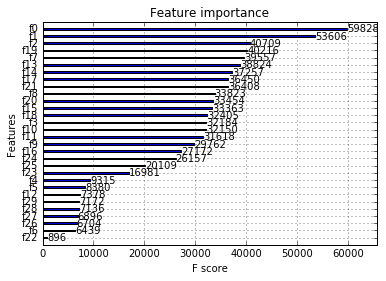

In [167]:
xgb.plot_importance(bst)

In [249]:
header_xgbsorted=[header_all[0],
              header_all[1],
              header_all[2],
              header_all[19],
              header_all[7],
              header_all[13],
              header_all[14],
              header_all[17],
              header_all[21],
              header_all[8],
              header_all[20],
              header_all[15],
              header_all[18],
              header_all[3],
              header_all[10],
              header_all[11],
              header_all[9],
              header_all[16],
              header_all[24],
              header_all[25],
              header_all[23],
              header_all[4],
              header_all[5],
              header_all[12],
              header_all[29],
              header_all[28],
              header_all[27],
              header_all[26],
              header_all[6],
              header_all[22],
              ]

In [256]:
header_final10 = header_xgbsorted[:10]
train_final10 = kD._extractFeatures(header_final10,train_data,train_header).astype(float)
test_final10 = kD._extractFeatures(header_final10,test_data,test_header).astype(float)

In [258]:
%%capture
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=3000,depth=9,eta=0.01,threshold=0.14,featListName="header_all")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=3000,depth=9,eta=0.01,threshold=0.14,featListName="header_1")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=3000,depth=9,eta=0.01,threshold=0.14,featListName="header_x")

In [87]:
def xgbmodel(data,label,weight,steps=100,depth=100,eta=0.1):
    # rescale weight to make it same as test set
    weight = weight * float(550000) / len(label)

    sum_wpos = sum( weight[i] for i in range(len(label)) if label[i] == 1.0  )
    sum_wneg = sum( weight[i] for i in range(len(label)) if label[i] == 0.0  )
    
    # print weight statistics 
    print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))
    
    # construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
    xgmat = xgb.DMatrix( data, label=label, missing = -999.0, weight=weight )
    
    # setup parameters for xgboost
    param = {}
    # use logistic regression loss, use raw prediction before logistic transformation
    # since we only need the rank
    param['objective'] = 'binary:logitraw'
    #param['objective'] = 'binary:logistic'
    # scale weight of positive examples
    #e 0.07 s 0.95 m 8 round 120
    param['scale_pos_weight'] = sum_wneg/sum_wpos
    param['eta'] = eta
    param['max_depth'] = depth
    #param['bst:max_depth'] = int(sys.argv[2])
    param['subsample'] = 0.9
    param['eval_metric'] = 'auc'
    #param['eval_metric'] = 'error'
    param['silent'] = 1
    param['nthread'] = 16
    
    # you can directly throw param in, though we want to watch multiple metrics here 
    plst = list(param.items())+[('eval_metric', 'ams@0.14')]    
    
    watchlist = [ (xgmat,'train') ]
    # boost 120 tres
    num_round = steps
    #num_round = 200
    print ('loading data end, start to boost trees')
    bst = xgb.train( plst, xgmat, num_round, watchlist );
    
    # save out model
    bst.save_model('higgs.model.%dstep.depth%s'%(steps,depth))

In [88]:
def xgbpredict(tdata,idx,steps=100,depth=9):
    modelfile = 'higgs.model.%dstep.depth%s'%(steps,depth)
    xgmat = xgb.DMatrix( tdata, missing = -999.0 )
    bst = xgb.Booster({'nthread':16})
    bst.load_model( modelfile )
    ypred = bst.predict( xgmat )

    res  = [ ( int(idx[i]), ypred[i] ) for i in range(len(ypred)) ] 

    rorder = {}
    for k, v in sorted( res, key = lambda x:-x[1] ):
        rorder[ k ] = len(rorder) + 1
    return rorder,res

In [89]:
def genpred(rorder,res,threshold_ratio=0.14):
    ntop = int( threshold_ratio * len(rorder ) )
    pred = np.empty([550000,1])
    for i in range(0,550000):
        event = res[i][0]
        if rorder[event] <= ntop:
            pred[i] = 1
        else:
            pred[i] = 0
    return pred

In [138]:
def getXGB_CVscore(data,label,weight,depth,eta):
    # rescale weight to make it same as test set
    weight = weight * float(550000) / len(label)

    sum_wpos = sum( weight[i] for i in range(len(label)) if label[i] == 1.0  )
    sum_wneg = sum( weight[i] for i in range(len(label)) if label[i] == 0.0  )
    
    # construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
    xgmat = xgb.DMatrix( data, label=label, missing = -999.0, weight=weight )
    
    # setup parameters for xgboost
    param = {}
    # use logistic regression loss, use raw prediction before logistic transformation
    # since we only need the rank
    param['objective'] = 'binary:logitraw'
    #param['objective'] = 'binary:logistic'
    # scale weight of positive examples
    #e 0.07 s 0.95 m 8 round 120
    param['scale_pos_weight'] = sum_wneg/sum_wpos
    param['eta'] = eta
    param['max_depth'] = depth
    #param['bst:max_depth'] = int(sys.argv[2])
    param['subsample'] = 0.9
    param['eval_metric'] = 'auc'
    #param['eval_metric'] = 'ams@0.15'
    #param['eval_metric'] = 'error'
    param['silent'] = 1
    param['nthread'] = 16
    
    plst = list(param.items())+[('eval_metric', 'ams@0.14')]
    
    cval = xgb.cv(plst,xgmat)
    
    return np.mean(cval.get_values()[:,0])

In [147]:
def run_xgb(train_data,label,weight,test_data,idx,timed=False,steps=100,depth=9,eta=0.1,threshold=0.14,featListName="not specified"):
    cvs=getXGB_CVscore(train_data,label,weight,depth,eta)
    
    if timed:
        start = time.time()
    
    xgbmodel(train_data,label,weight,steps,depth,eta)
    
    if timed:
        end = time.time()
        time_train = end - start
        start = time.time()
    
    rorder,res = xgbpredict(test_data,idx,steps,depth)
    pred = genpred(rorder,res,threshold_ratio=threshold)
    
    if timed:
        end = time.time()
        time_test = end - start
    
    b_ams,v_ams = tb.calcSetAMS(pred,sol_data)
    print("Public AMS:",b_ams[0],"|| Private AMS:",v_ams[0],"|| Threshold:", threshold)
    
    #save run-stats
    res=np.empty((20,),dtype="<U16")
    res[:14]=["xgboost",
            featListName,
            str(cvs),
            str(b_ams[0]),
            str(v_ams[0]),
            str(time_train),
            str(time_test),
            str("threshold="+str(0.14)),
            str("steps_="+str(steps)),
            str("depth_="+str(depth)),
            str("eta_="+str(eta)),
            str("subsample_=0.9"),
            str("eval_1=auc"),
            str("eval_2=ams@0.14"),
            ]
            
    res[11:]="None"
    tb.recordRun(res)
    
    return pred

In [98]:
%%capture
dump = run_kNN(train_1,train_labels,test_1,k=100,featListName="header_1")
dump = run_kNN(train_1,train_labels,test_1,k=200,featListName="header_1")
dump = run_kNN(train_2,train_labels,test_2,k=50,featListName="header_2")
dump = run_kNN(train_2,train_labels,test_2,k=100,featListName="header_2")
dump = run_kNN(train_3,train_labels,test_3,k=50,featListName="header_3")
dump = run_kNN(train_3,train_labels,test_3,k=100,featListName="header_3")
dump = run_kNN(train_4,train_labels,test_4,k=50,featListName="header_4")
dump = run_kNN(train_4,train_labels,test_4,k=100,featListName="header_4")
dump = run_kNN(train_5,train_labels,test_5,k=50,featListName="header_5")
dump = run_kNN(train_5,train_labels,test_5,k=100,featListName="header_5")
dump = run_kNN(train_6,train_labels,test_6,k=50,featListName="header_6")
dump = run_kNN(train_6,train_labels,test_6,k=100,featListName="header_6")
dump = run_kNN(train_7,train_labels,test_7,k=50,featListName="header_7")
dump = run_kNN(train_7,train_labels,test_7,k=100,featListName="header_7")
dump = run_kNN(train_8,train_labels,test_8,k=50,featListName="header_8")
dump = run_kNN(train_8,train_labels,test_8,k=100,featListName="header_8")
dump = run_kNN(train_x,train_labels,test_x,k=50,featListName="header_x")
dump = run_kNN(train_x,train_labels,test_x,k=100,featListName="header_x")
dump = run_kNN(train_all,train_labels,test_all,k=50,featListName="header_all")
dump = run_kNN(train_all,train_labels,test_all,k=100,featListName="header_all")

In [99]:
%%capture
dump = runLogReg(train_1,train_labels,test_1,C=0.1,timed=True,featListName="header_1")
dump = runLogReg(train_2,train_labels,test_2,C=0.1,timed=True,featListName="header_2")
dump = runLogReg(train_2,train_labels,test_2,C=1.0,timed=True,featListName="header_2")
dump = runLogReg(train_3,train_labels,test_3,C=0.1,timed=True,featListName="header_3")
dump = runLogReg(train_3,train_labels,test_3,C=1.0,timed=True,featListName="header_3")
dump = runLogReg(train_4,train_labels,test_4,C=0.1,timed=True,featListName="header_4")
dump = runLogReg(train_4,train_labels,test_4,C=1.0,timed=True,featListName="header_4")
dump = runLogReg(train_5,train_labels,test_5,C=0.1,timed=True,featListName="header_5")
dump = runLogReg(train_5,train_labels,test_5,C=1.0,timed=True,featListName="header_5")
dump = runLogReg(train_6,train_labels,test_6,C=0.1,timed=True,featListName="header_6")
dump = runLogReg(train_6,train_labels,test_6,C=1.0,timed=True,featListName="header_6")
dump = runLogReg(train_7,train_labels,test_7,C=0.1,timed=True,featListName="header_7")
dump = runLogReg(train_7,train_labels,test_7,C=1.0,timed=True,featListName="header_7")
dump = runLogReg(train_8,train_labels,test_8,C=0.1,timed=True,featListName="header_8")
dump = runLogReg(train_8,train_labels,test_8,C=1.0,timed=True,featListName="header_8")
dump = runLogReg(train_x,train_labels,test_x,C=0.1,timed=True,featListName="header_x")
dump = runLogReg(train_x,train_labels,test_x,C=1.0,timed=True,featListName="header_x")
dump = runLogReg(train_all,train_labels,test_all,C=0.1,timed=True,featListName="header_all")

In [148]:
%%capture
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=120,depth=6,eta=0.1,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=1200,depth=6,eta=0.1,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=120,depth=6,eta=0.01,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=1200,depth=6,eta=0.01,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=100,depth=9,eta=0.1,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=1000,depth=9,eta=0.1,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=100,depth=9,eta=0.01,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=1000,depth=9,eta=0.01,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=100,depth=12,eta=0.1,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=1000,depth=12,eta=0.1,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=100,depth=12,eta=0.01,threshold=0.14,featListName="header_x")
dump = run_xgb(train_x,train_labels,train_weights,test_x,test_events,timed=True,steps=1000,depth=12,eta=0.01,threshold=0.14,featListName="header_x")

In [149]:
%%capture
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=120,depth=6,eta=0.1,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=1200,depth=6,eta=0.1,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=120,depth=6,eta=0.01,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=1200,depth=6,eta=0.01,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=100,depth=9,eta=0.1,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=1000,depth=9,eta=0.1,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=100,depth=9,eta=0.01,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=1000,depth=9,eta=0.01,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=100,depth=12,eta=0.1,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=1000,depth=12,eta=0.1,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=100,depth=12,eta=0.01,threshold=0.14,featListName="header_1")
dump = run_xgb(train_1,train_labels,train_weights,test_1,test_events,timed=True,steps=1000,depth=12,eta=0.01,threshold=0.14,featListName="header_1")

In [150]:
%%capture
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=120,depth=6,eta=0.1,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=1200,depth=6,eta=0.1,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=120,depth=6,eta=0.01,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=1200,depth=6,eta=0.01,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=100,depth=9,eta=0.1,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=1000,depth=9,eta=0.1,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=100,depth=9,eta=0.01,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=1000,depth=9,eta=0.01,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=100,depth=12,eta=0.1,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=1000,depth=12,eta=0.1,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=100,depth=12,eta=0.01,threshold=0.14,featListName="header_6")
dump = run_xgb(train_6,train_labels,train_weights,test_6,test_events,timed=True,steps=1000,depth=12,eta=0.01,threshold=0.14,featListName="header_6")

In [151]:
%%capture
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=120,depth=6,eta=0.1,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=1200,depth=6,eta=0.1,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=120,depth=6,eta=0.01,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=1200,depth=6,eta=0.01,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=100,depth=9,eta=0.1,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=1000,depth=9,eta=0.1,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=100,depth=9,eta=0.01,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=1000,depth=9,eta=0.01,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=100,depth=12,eta=0.1,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=1000,depth=12,eta=0.1,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=100,depth=12,eta=0.01,threshold=0.14,featListName="header_all")
dump = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,steps=1000,depth=12,eta=0.01,threshold=0.14,featListName="header_all")

# Section Featureselection by PRI_jet_num

In [ ]:
def getFullDataByFeatureValue(data,header,feature,value,events = None,labels = None):
    new_events = None
    if events is not None:
        new_events = []
        
    new_labels = None
    if labels is not None:
        new_labels = []
    
    f_index = header.index(feature)
    new_data = []
    for i in range(0,len(data)):
        if data[i,f_index]==value:
            new_data.append(data[i,:])
            
            if events is not None:
                new_events.append(events[i])
            if labels is not None:
                new_labels.append(labels[i])
            
    return np.array(new_data),np.array(new_events),np.array(new_labels)

In [ ]:
train_jet0_data,dump,train_jet0_labels = getFullDataByFeatureValue(train_all,header_all,"PRI_jet_num",0.,labels = train_labels)
train_jet1_data,dump,train_jet1_labels = getFullDataByFeatureValue(train_all,header_all,"PRI_jet_num",1.,labels = train_labels)
train_jet2_data,dump,train_jet2_labels = getFullDataByFeatureValue(train_all,header_all,"PRI_jet_num",2.,labels = train_labels)
train_jet3_data,dump,train_jet3_labels = getFullDataByFeatureValue(train_all,header_all,"PRI_jet_num",3.,labels = train_labels)

test_jet0_data,test_jet0_events = getFullDataByFeatureValue(test_all,header_all,"PRI_jet_num",0.,events = test_events)[:-1]
test_jet1_data,test_jet1_events = getFullDataByFeatureValue(test_all,header_all,"PRI_jet_num",1.,events = test_events)[:-1]
test_jet2_data,test_jet2_events = getFullDataByFeatureValue(test_all,header_all,"PRI_jet_num",2.,events = test_events)[:-1]
test_jet3_data,test_jet3_events = getFullDataByFeatureValue(test_all,header_all,"PRI_jet_num",3.,events = test_events)[:-1]

In [ ]:
def getDataBy_jet_num(data,header,jet_num):
    
    new_header = header.copy()
    
    if jet_num == 2 or jet_num == 3:
        return data,new_header
    if jet_num == 0:
        header_errors=['DER_deltaeta_jet_jet',
                       'DER_mass_jet_jet',
                       'DER_prodeta_jet_jet',
                       'DER_lep_eta_centrality',
                       'PRI_jet_subleading_pt',
                       'PRI_jet_subleading_eta',
                       'PRI_jet_subleading_phi',
                       'PRI_jet_leading_pt',
                       'PRI_jet_leading_eta',
                       'PRI_jet_leading_phi']
    if jet_num == 1:
        header_errors=['DER_deltaeta_jet_jet',
                       'DER_mass_jet_jet',
                       'DER_prodeta_jet_jet',
                       'DER_lep_eta_centrality',
                       'PRI_jet_subleading_pt',
                       'PRI_jet_subleading_eta',
                       'PRI_jet_subleading_phi']
        
    for feature in header_errors:
        try:
            new_header.remove(feature)
        except:
            print(feature, "not found in data, continuing...")
    
    new_data = kD._extractFeatures(new_header,data,header).astype(float)
        
    return new_data,new_header

In [ ]:
train_jet23_data = np.vstack((train_jet2_data,train_jet3_data))
train_jet23_labels = np.hstack((train_jet2_labels,train_jet3_labels))

test_jet23_data = np.vstack((test_jet2_data,test_jet3_data))
test_jet23_events = np.hstack((test_jet2_events,test_jet3_events))

In [ ]:
train_jet0_data,train_jet0_header = getDataBy_jet_num(train_jet0_data,header_all,0)
train_jet1_data,train_jet1_header = getDataBy_jet_num(train_jet1_data,header_all,1)
train_jet23_data,train_jet23_header = getDataBy_jet_num(train_jet23_data,header_all,2)

test_jet0_data,test_jet0_header = getDataBy_jet_num(test_jet0_data,header_all,0)
test_jet1_data,test_jet1_header = getDataBy_jet_num(test_jet1_data,header_all,1)
test_jet23_data,test_jet23_header = getDataBy_jet_num(test_jet23_data,header_all,2)

In [ ]:
h_jet0_pred,s_jet0_pred = kNN(train_jet0_data,train_jet0_labels,test_jet0_data,timed=True,k=20,thresh=0.5)
h_jet1_pred,s_jet1_pred = kNN(train_jet1_data,train_jet1_labels,test_jet1_data,timed=True,k=20,thresh=0.5)
h_jet23_pred,s_jet23_pred = kNN(train_jet23_data,train_jet23_labels,test_jet23_data,timed=True,k=20,thresh=0.5)

In [ ]:
s_final_pred = np.hstack((s_jet0_pred[:,1],s_jet1_pred[:,1],s_jet23_pred[:,1]))
h_final_pred = np.hstack((h_jet0_pred,h_jet1_pred,h_jet23_pred))
final_events = np.hstack((test_jet0_events,test_jet1_events,test_jet23_events))

In [ ]:
order = final_events.argsort()
s_final_pred = np.take(s_final_pred, order, 0)
h_final_pred = np.take(h_final_pred, order, 0)
final_events.sort()

In [ ]:
tb.calcSetAMS(h_final_pred,sol_data)

In [ ]:
final_pred,dump,maxThresh=tb.bestThreshold(s_final_pred,sol_data)

In [ ]:
tb.calcSetAMS(final_pred,sol_data)